<h1 align='center'>Введение в обработку естественного языка</h1>  
<h2 align='center'>Урок 11. Модель Transformer-1</h2>  
Практическое задание:  

Реализовать суммаризацию текста

Датасет: gazeta.ru




Загрузим датасет и необходимые библиотеки

In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!ls

gazeta_test.txt  gazeta_train.txt  gazeta_val.txt  sample_data


In [ ]:
!pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy
!pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
!python -m spacy download ru_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 124.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 126.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for summa: filename=sum

## Загрузим данные с помощью библиотеки datasets

In [ ]:
# по сути данные те же можно пользоваться любым способом загрузки
from datasets import load_dataset

dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## EDA (Exploratory data analysis)

### Dataset

Посмотрим на то, как устроен датасет

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
test_records[0]

{'url': 'https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, к

In [ ]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [ ]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


### Statistics

[Проблемы токенизации](https://natasha.github.io/razdel/)

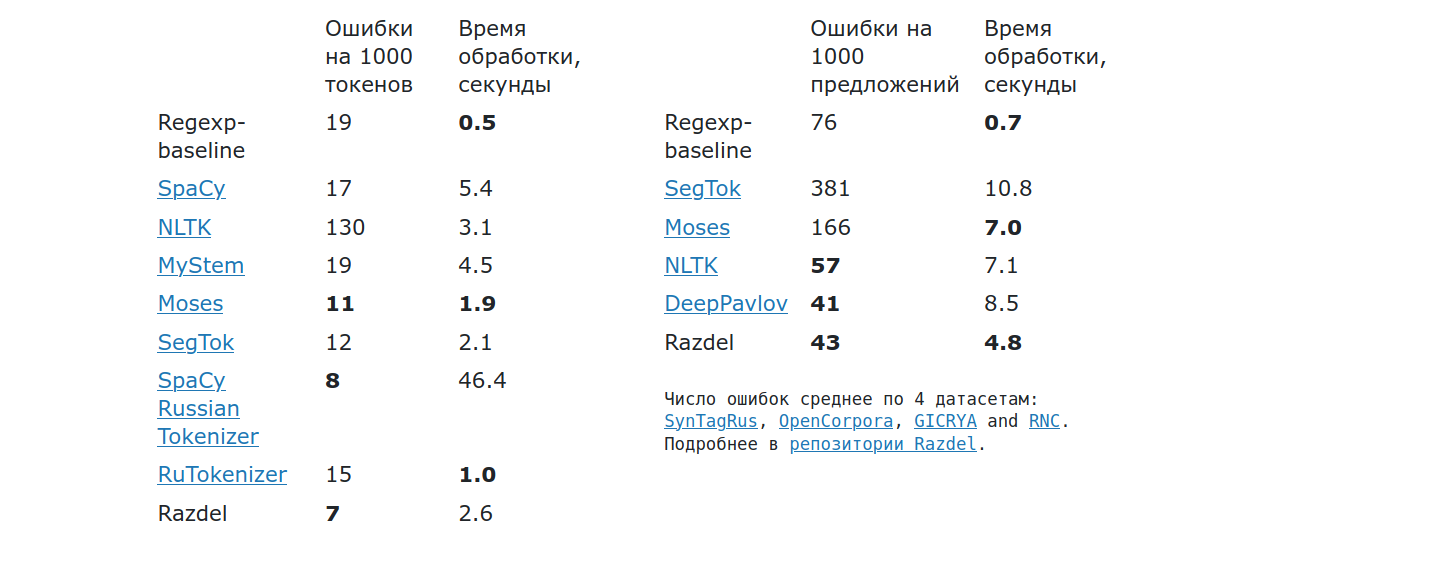

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)


In [ ]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [ ]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


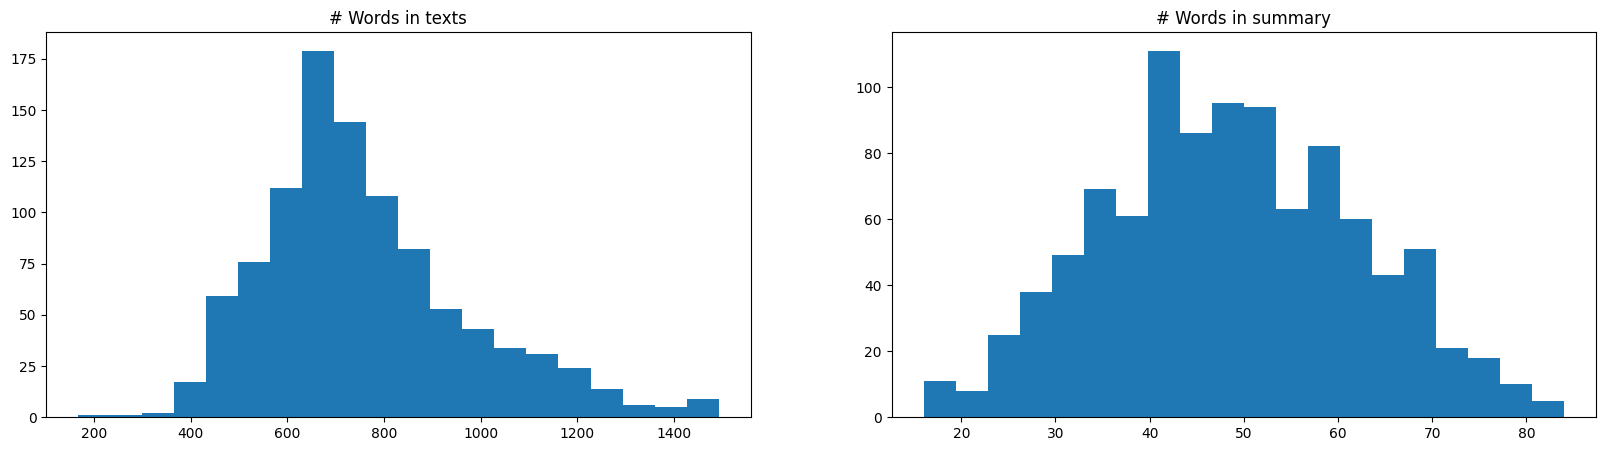

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Lead-3

Первый baseline - первые 3 предложения текста в качестве summary.


В качестве метрик здесь и далее используем BLEU и [ROUGE](https://).<br><br>

* **ROUGE-N** – измеряет перекрытие униграмм, биграмм, триграмм и n-грамм более высокого порядка
* **ROUGE-L** – измеряет самую длинную совпадающую последовательность слов с помощью LCS. Преимущество использования LCS заключается в том, что для этого требуются не последовательные совпадения, а последовательные совпадения, отражающие порядок слов на уровне предложения. Поскольку он автоматически включает самые длинные в последовательности общие n-граммы, вам не нужна заранее определенная длина n-грамма.

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [ ]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'r': 0.37762764047433917, 'p': 0.22208274285774904, 'f': 0.23804097238957525}, 'rouge-2': {'r': 0.15833772153385062, 'p': 0.09647636782929753, 'f': 0.10027796832321115}, 'rouge-l': {'r': 0.34937017731940756, 'p': 0.2022959168891477, 'f': 0.21799992093276083}}


## Метод Луна

Метод Луна — первый эвристический метод автоматического реферирования. Он был описан в 1958 году в статье Ханса Петера Луна и реализован на IBM 704.

В современных терминах алгоритм звучит так:


* Вычисляем значимые слова документа:
    * Делаем стемминг или лемматизацию слов: разные словоформы одной леммы должны считаться как одно слово.
    * Считаем частоты слов, формируем список слов по убыванию частоты.
    * Убираем стоп-слова: частотные слова, у которых нет отдельной смысловой нагрузки, например предлоги и частицы.
    * Убираем слишком редкие слова, например такие, которые встречаются только 1 раз, либо убираем какой-то перцентиль слов по частоте.
    * Все оставшиеся слова считаем значимыми.
* Считаем значимость для предложений:
    * Предложение делим на промежутки, которые начинаются и заканчиваются значимыми словами. В промежутке могут быть и незначимые слова, но не более 4 подряд.
    * Значимость промежутка — квадрат количества значимых слов в промежутке, делённый на размер промежутка.
    * Значимость предложения — максимум из значимостей промежутков.
* Берём в качестве реферата предложения со значимостью выше определённого порога.

Пример вычисления значимости предложения приведён на рисунке ниже. Красным обозначены стоп-слова, фиолетовым — незначимые слова, а зелёным — значимые слова.



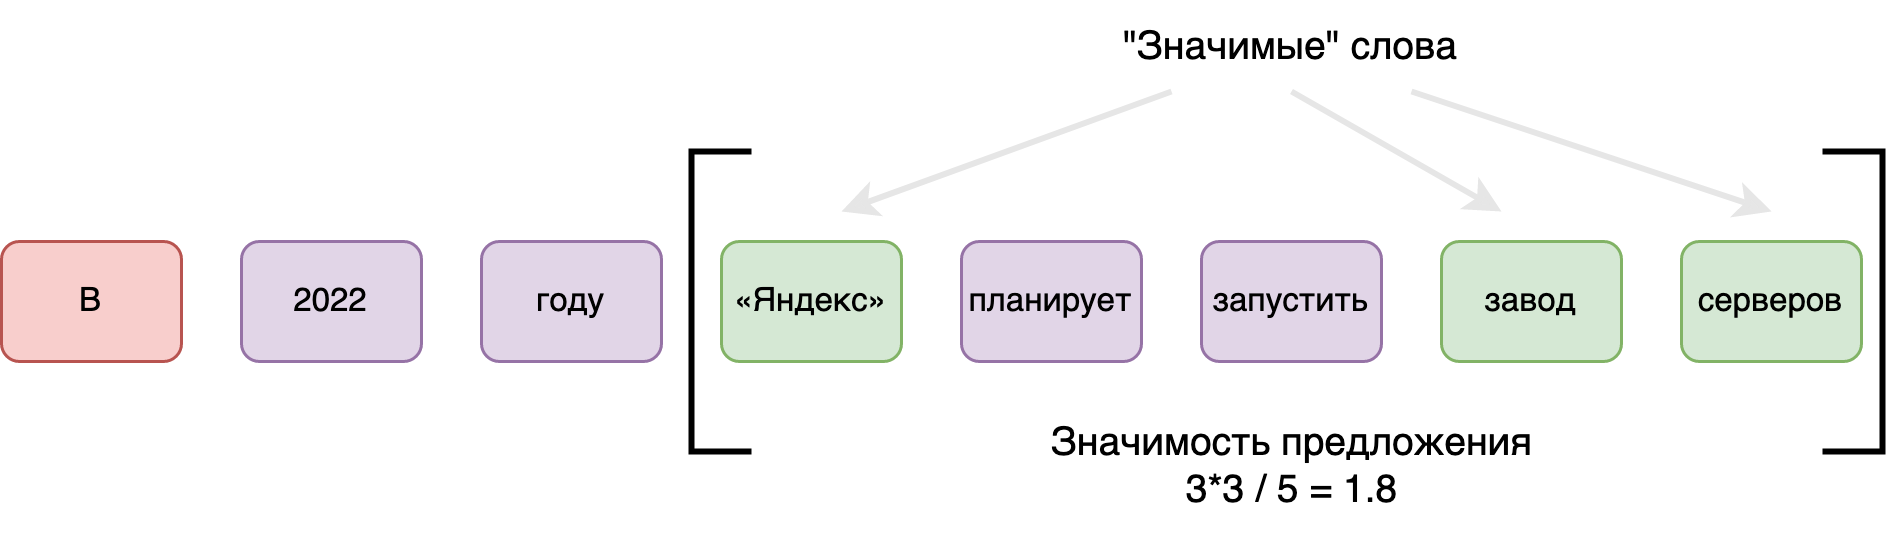

Несмотря на свою простоту, метод Луна до сих пор используется в современных программных комплексах.


In [ ]:
# Делаем предобработку

import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие']
['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'американский', 'научный', 'команда', 'котором', 'участвовать', 'десять', 'миссия', 'они', 'были', 'отобрать', 'критерий', 'потенциальный', 'польза', 'наука', 'технический', 'осуществимость', 'проект', 'рамка', 'программа', 'discovery', 'nasa', 'заниматься', 'планирование', 'миссия', 'которые', 'призваны', 'дать', 'ответ', 'фундаментальный', 'вопрос', 'происхождение', 'тело', 'солнечный', 'система', 'возможный', 'наличие

In [ ]:
from collections import Counter

class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.
            sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens
            
            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False
        
        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk): 
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [ ]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 

## TextRank

https://habr.com/ru/post/455762/

TextRank - unsupervised метод для составления кратких выжимок из текста. 
Описание метода:

1. Сплитим текст по предложениям
2. Считаем "похожесть" предложений между собой
3. Строим граф предложений с взвешенными ребрами
4. С помощью алгоритм PageRank получаем наиболее важные предложения, на основе которых делаем summary.

### Самописный TextRank

In [ ]:
from itertools import combinations
import networkx as nx
import pymorphy2
import numpy as np
from tqdm.notebook import tqdm

def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    ''' 
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2)) / (len(words1) + len(words2))
    #return len(words1.intersection(words2)) / (np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank
    
    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # # Выбираем топ предложений
    # n_summary_sentences = max(int(n_sentences * summary_part), 1)
    # result = result[:BLEU:  0.531336150784986*n_summary_sentences]


    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])
    
    num_sents = len(result)
    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary, num_sents

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []
    length_sents = [] 

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, num_sents = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        length_sents.append(num_sents)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    print(f'Mean number of sents in summary: {np.mean(length_sents)}')
    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)

0it [00:00, ?it/s]

Mean number of sents in summary: 37.321
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. «здесь только ты и бог. проект-откровение. узнай себя и мир монастырской жизни. одна из красивейших обителей россии на озере селигер. проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. в комментарии также отмечается, что это беспрецедентный подобный проек

Сделаем TextRank с другой мерой близости предложений: по FastText, ELMo или BERT эмбеддингам

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install navec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



<img src="https://raw.githubusercontent.com/natasha/natasha-logos/master/navec.svg">
<br>


[Navec](https://github.com/natasha/navec)

можно сделать то же но на трансформерах, взять бертовые эмбединги

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2023-05-25 08:15:33--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  13.6MB/s    in 1.9s    

2023-05-25 08:15:36 (13.6 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



In [ ]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path) 

In [ ]:
from numpy.linalg import norm
def vectorize_sum(words, embeddings):

    embedding_dim = embeddings['example'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')

    num_known_words = 0
    for word in words:
        if word in embeddings:
            num_known_words += 1
            features += embeddings[f'{word}']

    if num_known_words:
        return features / num_known_words
    else: return features

def my_sim(text1, text2, embeddings=navec, kind='cos'):

    v1, v2 = vectorize_sum(text1, embeddings), vectorize_sum(text2, embeddings)
    if np.sum(v1) == 0.0 or np.sum(v2) == 0.0:
        return 0 

    return np.abs(np.dot(v1, v2) / norm(v1) / norm(v2))

In [ ]:
calc_text_rank_score(test_records, calc_similarity=my_sim, morph=morph)

0it [00:00, ?it/s]

Mean number of sents in summary: 37.321
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. «здесь только ты и бог. проект-откровение. узнай себя и мир монастырской жизни. одна из красивейших обителей россии на озере селигер. проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. в комментарии также отмечается, что это беспрецедентный подобный проек

## Lexrank
* Original paper: https://arxiv.org/pdf/1109.2128.pdf
* lexrank library: https://github.com/crabcamp/lexrank

In [ ]:
def calc_method_score(records, predict_func, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)

    calc_scores(references, predictions)

In [ ]:
!pip install lexrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lexrank-0.1.0-py3-none-any.whl (69 kB)
  Using cached path.py-12.5.0-py3-none-any.whl (2.3 kB)
  Using cached urlextract-1.8.0-py3-none-any.whl (21 kB)
  Using cached path-16.6.0-py3-none-any.whl (26 kB)
  Using cached uritools-4.0.1-py3-none-any.whl (10 kB)


In [ ]:
import lexrank
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS


def predict_lex_rank(text, summary, lxr, summary_size=3, threshold=None):
    sentences = [s.text for s in razdel.sentenize(text)]
    prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
    prediction = " ".join(prediction)
    return prediction
    

sentences = [[s.text for s in razdel.sentenize(r["text"])] for r in test_records]
lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
calc_method_score(test_records, lambda x, y: predict_lex_rank(x, y, lxr))

Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: РПЦ же нередко критикует СМИ. Критиковали в РПЦ и популярность футбола – об этом заявлял также Смирнов. В июне нынешнего года сообщалось, что РПЦ планирует сделать из Сергиева Посада «православный Ватикан».
BLEU:  0.3585872220880093
ROUGE:  {'rouge-1': {'r': 0.2055701577098893, 'p': 0.18137864753781832, 'f': 0.1866598392888999}, 'rouge-2': {'r': 0.06670656927927147, 'p': 0.05407660852215697, 'f': 0.05775558829470266}, 'rouge-l': {'r': 0.18766952121068614, 'p': 0.16619633248764337, 'f': 0.1707256638500182}}


## LSA
* One of the original papers: https://www.cs.bham.ac.uk/~pxt/IDA/text_summary.pdf
* sumy library: https://github.com/miso-belica/sumy

In [ ]:
!pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sumy-0.11.0-py2.py3-none-any.whl (97 kB)
  Using cached breadability-0.1.20-py2.py3-none-any.whl
  Using cached pycountry-22.3.5-py2.py3-none-any.whl


In [ ]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
import nltk; nltk.download('punkt');


def predict_lsa(text, summary, lsa_summarizer, tokenizer, summary_size=3):
    parser = PlaintextParser.from_string(text, tokenizer)
    predicted_summary = lsa_summarizer(parser.document, summary_size)
    predicted_summary = " ".join([str(s) for s in predicted_summary])
    return predicted_summary

lsa_summarizer = LsaSummarizer()
tokenizer = Tokenizer("russian")
calc_method_score(test_records, lambda x, y: predict_lsa(x, y, lsa_summarizer, tokenizer))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Count: 1000
Ref: Телеканал «Спас» запускает реалити-шоу «Остров», участникам которого предстоит месяц жить и работать в Нило-Столобенской пустыни на озере Селигер. Организаторы отметили, что это беспрецедентный подобный проект на телевидении. Участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: Проживи месяц в Ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. Известный миссионер, председатель Синодального отдела МП по взаимодействию с Вооруженными силами и правоохранительными учреждениями протоиерей Дмитрий Смирнов выразил надежду, что проект даст благие результаты. По его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегуманизации» личности, уводя в виртуальную реальность.
BLEU:  0.2890038325201829
ROUGE:  {'rouge-1': {'r': 0.1896206300346558, 'p':

### Summa

In [ ]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached summa-1.2.0-py3-none-any.whl


In [ ]:
from summa.summarizer import summarize
from tqdm.notebook import tqdm

def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'r': 0.24737876331285494, 'p': 0.14391909693539454, 'f': 0.17704254978777

## Oracle summary

Для сведения задачи к extractive summarization мы должны выбрать те предложения из оригинального текста, которые наиболее похожи на наше целевое summary по нашим метрикам.

In [ ]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [ ]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'r': 0.3661389123393327, 'p': 0.4053281117404892, 'f': 0.36951810858804146}, 'rouge-2': {'r': 0.2059449963901

## RNN

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.DataFrame(train_records)

In [ ]:
df_test = pd.DataFrame(test_records)
df_test[:3]

,url,text,title,summary,date
0,https://www.gazeta.ru/science/2020/02/14_a_129...,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA","В NASA назвали четыре миссии в дальний космос,...",2020-02-14 16:39:11
1,https://www.gazeta.ru/social/2020/02/28/129806...,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,25 и 26 февраля в Кремлевском дворце съездов п...,2020-02-28 10:44:13
2,https://www.gazeta.ru/politics/2019/11/07_a_12...,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,В Белоруссии в день годовщины Октябрьской рево...,2019-11-07 19:55:08


In [ ]:
df_train[:5]

,url,text,title,summary,date
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14
3,https://www.gazeta.ru/business/2013/06/21/5388...,Как повлияло вступление в ВТО на конкурентносп...,«С последних традиционно «отжимают» больше»,Мнения предпринимателей по поводу вступления в...,2013-06-21 17:43:50
4,https://www.gazeta.ru/culture/2014/12/27/a_636...,К третьему сезону «Голос» на Первом канале ста...,Третий «Голос» за Градского,На Первом канале завершился третий сезон шоу «...,2014-12-27 01:10:01


In [ ]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_train['summary_clean'][:5]

0    BOS В 2011 году из России уйдет $80 млрд, счит...
1    BOS Юлия Соловьева, экс-директор холдинга «Про...
2    BOS Суд арестовал на два месяца четверых экс-ч...
3    BOS Мнения предпринимателей по поводу вступлен...
4    BOS На Первом канале завершился третий сезон ш...
Name: summary_clean, dtype: object

In [ ]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200

df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_len_text = 700
max_len_sum = 70

In [ ]:
#tok_text = Tokenizer(oov_token='UNK')
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [ ]:
text_vocab_size=len(tok_text.word_index)+1

padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [ ]:
#tok_sum = Tokenizer(oov_token='UNK')
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])

sum_vocab_size=len(tok_sum.word_index)+1

padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [ ]:
padded_x_train_sum.shape

(1000, 70)

In [ ]:
reverse_text_index=tok_text.index_word
reverse_sum_index=tok_sum.index_word
sum_wordindex=tok_sum.word_index

### Model

In [ ]:
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

In [ ]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 700, 200)     17664000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 700, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=10,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=16)

Epoch 1/10
63/63 [==============================] - 732s 11s/step - loss: 6.7539 - accuracy: 0.3781 - val_loss: 4.3202 - val_accuracy: 0.4946
Epoch 2/10
63/63 [==============================] - 695s 11s/step - loss: 5.3809 - accuracy: 0.3965 - val_loss: 3.9179 - val_accuracy: 0.5251
Epoch 3/10
63/63 [==============================] - 685s 11s/step - loss: 5.1226 - accuracy: 0.4101 - val_loss: 3.8754 - val_accuracy: 0.5296
Epoch 4/10
63/63 [==============================] - 681s 11s/step - loss: 5.0194 - accuracy: 0.4145 - val_loss: 3.8781 - val_accuracy: 0.5304
Epoch 5/10
63/63 [==============================] - 684s 11s/step - loss: 4.9304 - accuracy: 0.4159 - val_loss: 3.8896 - val_accuracy: 0.5299
Epoch 6/10
63/63 [==============================] - 694s 11s/step - loss: 4.8771 - accuracy: 0.4149 - val_loss: 3.9094 - val_accuracy: 0.5297
Epoch 7/10
63/63 [==============================] - 684s 11s/step - loss: 4.7807 - accuracy: 0.4167 - val_loss: 3.9375 - val_accuracy: 0.5275
Epoch 

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString


In [ ]:
for i in range(0, 3):
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:",seq2summary(padded_x_test_sum[i]))

    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

Original summary: в nasa назвали четыре миссии в космос которые в этом могут быть американцами среди них — две миссии по полет к и к 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  в россии в россии в первом матче в матче и матче и его рассказал в его его рассказал в словам и словам а в словам а в словам а в словам а в словам а в словам а в словам


Original summary: 25 и 26 февраля в праздновали — новый год центр российского и один из регионов страны где новый год официально дважды 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  в россии в россии в первом матче в матче и матче и два и его рассказал в его его рассказал в этом в словам и словам а в словам а в словам а в словам а в словам а в словам


Original summary: в белоруссии в день революции выбрали членов палаты парламента сегодняшнее голосование — основной части процесса через десять дней в республике пройдут выборы в палату представителей которые станут для александра лукашенко 

## Attention

In [ ]:
from tensorflow.keras.layers import GRU, AdditiveAttention

In [ ]:
df_train['text'],
df_train['summary_clean']

0      BOS В 2011 году из России уйдет $80 млрд, счит...
1      BOS Юлия Соловьева, экс-директор холдинга «Про...
2      BOS Суд арестовал на два месяца четверых экс-ч...
3      BOS Мнения предпринимателей по поводу вступлен...
4      BOS На Первом канале завершился третий сезон ш...
                             ...                        
995    BOS Банки исчерпывают точки роста, обеспечивав...
996    BOS В условиях экономической стагнации именно ...
997    BOS Еврочиновники приняли мандат на ведение пе...
998    BOS В Грузии в районе Панкисского ущелья постр...
999    BOS Коррупцию в России не удастся победить еще...
Name: summary_clean, Length: 1000, dtype: object

In [ ]:
BUFFER_SIZE = len(padded_x_train)
BATCH_SIZE = 32
steps_per_epoch = len(padded_x_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, padded_x_train_sum)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 700]), TensorShape([32, 70]))

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru1(x, initial_state = hidden)
        output, state = self.gru2(output, initial_state = state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, x, query, value):
        # enc_output shape == (batch_size, max_length, hidden_size)
        #attention_weights = self.attention([ tf.expand_dims(query, 1), value,])
        context_vector = self.attention([tf.expand_dims(query, 1), value,])
        #context_vector = tf.squeeze(context_vector)


        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [ ]:
latent_dim = 300
embedding_dim=200

In [ ]:
encoder = Encoder(text_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
decoder = Decoder(sum_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([sum_wordindex['bos']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
checkpoint_dir = './training_summ_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.8761
Epoch 1 Batch 10 Loss 5.5689
Epoch 1 Batch 20 Loss 5.3188
Epoch 1 Batch 30 Loss 5.5591
Epoch 1 Loss 5.5483
Time taken for 1 epoch 109.67587184906006 sec

Epoch 2 Batch 0 Loss 5.3190
Epoch 2 Batch 10 Loss 5.3325
Epoch 2 Batch 20 Loss 4.8012
Epoch 2 Batch 30 Loss 5.0849
Epoch 2 Loss 5.1614
Time taken for 1 epoch 21.078269481658936 sec

Epoch 3 Batch 0 Loss 5.2040
Epoch 3 Batch 10 Loss 5.2292
Epoch 3 Batch 20 Loss 5.0474
Epoch 3 Batch 30 Loss 5.4057
Epoch 3 Loss 5.0330
Time taken for 1 epoch 19.936850547790527 sec

Epoch 4 Batch 0 Loss 5.0250
Epoch 4 Batch 10 Loss 4.4918
Epoch 4 Batch 20 Loss 5.2527
Epoch 4 Batch 30 Loss 4.9984
Epoch 4 Loss 4.9616
Time taken for 1 epoch 21.279900074005127 sec

Epoch 5 Batch 0 Loss 4.6698
Epoch 5 Batch 10 Loss 4.8822
Epoch 5 Batch 20 Loss 4.9724
Epoch 5 Batch 30 Loss 4.7273
Epoch 5 Loss 4.8910
Time taken for 1 epoch 19.15496277809143 sec

Epoch 6 Batch 0 Loss 4.7033
Epoch 6 Batch 10 Loss 4.6641
Epoch 6 Batch 20 Loss 4.9517
Epoch

In [ ]:
tok_sum.word_index

{'в': 1,
 'bos': 2,
 'eos': 3,
 'и': 4,
 'на': 5,
 'с': 6,
 'по': 7,
 'не': 8,
 'что': 9,
 'за': 10,
 'из': 11,
 '—': 12,
 'а': 13,
 'к': 14,
 'о': 15,
 'россии': 16,
 'его': 17,
 'от': 18,
 'для': 19,
 'после': 20,
 'сша': 21,
 'как': 22,
 'но': 23,
 'он': 24,
 'года': 25,
 'до': 26,
 'будет': 27,
 'это': 28,
 'может': 29,
 'также': 30,
 'у': 31,
 'эксперты': 32,
 'при': 33,
 'уже': 34,
 'году': 35,
 'лет': 36,
 'во': 37,
 'ранее': 38,
 'время': 39,
 'словам': 40,
 'заявил': 41,
 'президент': 42,
 'который': 43,
 'однако': 44,
 '1': 45,
 'под': 46,
 'ее': 47,
 'еще': 48,
 'более': 49,
 'президента': 50,
 'которые': 51,
 'матче': 52,
 'со': 53,
 'над': 54,
 'мира': 55,
 'суд': 56,
 'владимир': 57,
 'этом': 58,
 'власти': 59,
 'только': 60,
 'был': 61,
 'млн': 62,
 'украины': 63,
 'их': 64,
 'всего': 65,
 'все': 66,
 '–': 67,
 'страны': 68,
 'против': 69,
 'пока': 70,
 'могут': 71,
 'лиги': 72,
 'стал': 73,
 'москве': 74,
 'российский': 75,
 'быть': 76,
 'экс': 77,
 'были': 78,
 'глава'

In [ ]:
def evaluate(sentence):
    inputs = [tok_text.word_index[i] for i in sentence.split(' ') if i !='']
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_len_text,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tok_sum.word_index['bos']], 0)

    for t in range(max_len_sum):
        predictions, dec_hidden = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)



        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tok_sum.index_word[predicted_id] + ' '

        if tok_sum.index_word[predicted_id] == 'eos':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [ ]:
def summ(sentence):
    result, sentence = evaluate(sentence)

    return result

In [ ]:
for i in range(3, 6):
    text2 = seq2text(padded_x_test[i])
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:", seq2summary(padded_x_test_sum[i]))
    print("Predicted summary: ", summ(text2.strip()))
    print("\n")

Original summary: народная артистка надежда в интервью рассказала о своей жизни в частности певица почему ее муж по поводу об их отношениях а также не смогла сдержать о смерти младшего 
Predicted summary:  инвесторы не стыдится собственного имени deathspank или «шлепок смерти» для друзей злодеев и сократить бюджетные дефициты говорят эксперты eos 


Original summary: украина не должна выплачивать пенсии и лнр поскольку они могут поддерживать россию заявила депутат верховной рады от партии елизавета она выступила против закона о праве на получение от государства для жителей донбасса по ее словам это в сторону тех кто уехал на украину и ничего не получил 
Predicted summary:  в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет только в россии флажками и не будет т

## mBART huggingface
* BART paper: https://arxiv.org/abs/1910.13461
* mBART paper: https://arxiv.org/abs/2001.08210
* Model: https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.8 MB/s eta 0:00:00


In [ ]:
import json
import torch
from tqdm.notebook import tqdm
from transformers import MBartTokenizer, MBartForConditionalGeneration


def gen_batch(inputs, batch_size):
    batch_start = 0
    while batch_start < len(inputs):
        yield inputs[batch_start: batch_start + batch_size]
        batch_start += batch_size


def predict(
    model_name,
    test_file,
    predictions_file,
    targets_file,
    max_source_tokens_count=600,
    max_target_tokens_count=160,
    use_cuda=True,
    batch_size=4
):
    inputs = []
    targets = []
    with open(test_file, "r") as r:
        for line in r:
            record = json.loads(line)
            inputs.append(record["text"])
            targets.append(record["summary"].replace("\n", " "))

    tokenizer = MBartTokenizer.from_pretrained(model_name)
    device = torch.device("cuda:0") if use_cuda else torch.device("cpu")
    model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)
    predictions = []
    for batch in tqdm(gen_batch(inputs, batch_size)):
        input_ids = tokenizer.prepare_seq2seq_batch(
            batch,
            src_lang="en_XX",
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_source_tokens_count
        )["input_ids"].to(device)
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_target_tokens_count + 2,
            no_repeat_ngram_size=3,
            num_beams=5,
            top_k=0
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        predictions.extend(summaries)
    with open(predictions_file, "w") as w:
        for p in predictions:
            w.write(p.strip() + "\n")
    with open(targets_file, "w") as w:
        for t in targets:
            w.write(t.strip() + "\n")

predict("IlyaGusev/mbart_ru_sum_gazeta", "gazeta_test.txt", "predictions.txt", "targets.txt")

In [ ]:
!ls

gazeta_test.txt   navec_news_v1_1B_250K_300d_100q.tar
gazeta_train.txt  sample_data
gazeta_val.txt	  training_summ_checkpoints
